In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
# !pip install tf-nightly-2.0-preview

In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)
%matplotlib inline

2.1.0


In [4]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [5]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
    dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

In [6]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
31/31 [==============================] - 3s 105ms/step - loss: 21.4956 - mae: 22.0115
Epoch 2/100
31/31 [==============================] - 0s 16ms/step - loss: 21.1128 - mae: 21.6440
Epoch 3/100
31/31 [==============================] - 1s 17ms/step - loss: 20.7468 - mae: 21.2278
Epoch 4/100
31/31 [==============================] - 1s 19ms/step - loss: 20.3564 - mae: 20.7739
Epoch 5/100
31/31 [==============================] - 1s 16ms/step - loss: 19.7907 - mae: 20.2843
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 19.1428 - mae: 19.6776
Epoch 7/100
31/31 [==============================] - 1s 16ms/step - loss: 18.2205 - mae: 18.7308
Epoch 8/100
31/31 [==============================] - 0s 15ms/step - loss: 17.5280 - mae: 17.9757
Epoch 9/100
31/31 [==============================] - 0s 15ms/step - loss: 17.1315 - mae: 17.6581
Epoch 10/100
31/31 [==============================] - 0s 16ms/step - loss: 16.8294 - mae: 17.3457
Epoch 11/100
31/31 [========

31/31 [==============================] - 0s 14ms/step - loss: 9.5785 - mae: 10.0445
Epoch 86/100
31/31 [==============================] - 0s 15ms/step - loss: 9.0401 - mae: 9.5522
Epoch 87/100
31/31 [==============================] - 0s 14ms/step - loss: 6.4075 - mae: 6.9088
Epoch 88/100
31/31 [==============================] - 0s 15ms/step - loss: 7.4137 - mae: 7.8881
Epoch 89/100
31/31 [==============================] - 1s 16ms/step - loss: 5.9400 - mae: 6.4147
Epoch 90/100
31/31 [==============================] - 0s 15ms/step - loss: 6.0968 - mae: 6.5790
Epoch 91/100
31/31 [==============================] - 0s 15ms/step - loss: 9.6629 - mae: 10.1893
Epoch 92/100
31/31 [==============================] - 0s 15ms/step - loss: 7.1868 - mae: 7.7053
Epoch 93/100
31/31 [==============================] - 0s 14ms/step - loss: 10.2599 - mae: 10.7193
Epoch 94/100
31/31 [==============================] - 0s 14ms/step - loss: 8.6694 - mae: 9.1838
Epoch 95/100
31/31 [=============================

(1e-08, 0.0001, 0.0, 30.0)

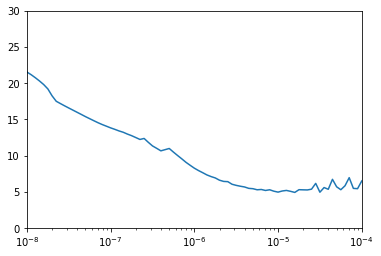

In [7]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [8]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9),metrics=["mae"])
history = model.fit(dataset,epochs=500,verbose=1)

Epoch 1/500
31/31 [==============================] - 4s 115ms/step - loss: 682.6678 - mae: 20.4758
Epoch 2/500
31/31 [==============================] - 1s 17ms/step - loss: 139.0910 - mae: 9.1305
Epoch 3/500
31/31 [==============================] - 0s 16ms/step - loss: 91.4935 - mae: 7.2219
Epoch 4/500
31/31 [==============================] - 0s 16ms/step - loss: 96.4645 - mae: 7.6917
Epoch 5/500
31/31 [==============================] - 1s 18ms/step - loss: 68.6789 - mae: 6.3048
Epoch 6/500
31/31 [==============================] - 1s 19ms/step - loss: 90.5751 - mae: 7.4939
Epoch 7/500
31/31 [==============================] - 1s 22ms/step - loss: 84.5246 - mae: 7.1350
Epoch 8/500
31/31 [==============================] - 1s 21ms/step - loss: 71.0016 - mae: 6.5040
Epoch 9/500
31/31 [==============================] - 1s 18ms/step - loss: 74.1523 - mae: 6.5122
Epoch 10/500
31/31 [==============================] - 1s 17ms/step - loss: 59.1190 - mae: 5.8587
Epoch 11/500
31/31 [===============

31/31 [==============================] - 0s 14ms/step - loss: 47.6147 - mae: 5.2165
Epoch 86/500
31/31 [==============================] - 0s 14ms/step - loss: 52.8832 - mae: 5.5653
Epoch 87/500
31/31 [==============================] - 0s 15ms/step - loss: 44.3334 - mae: 5.0196
Epoch 88/500
31/31 [==============================] - 0s 14ms/step - loss: 51.8781 - mae: 5.4605
Epoch 89/500
31/31 [==============================] - 0s 15ms/step - loss: 49.5481 - mae: 5.3673
Epoch 90/500
31/31 [==============================] - 0s 14ms/step - loss: 45.1209 - mae: 5.1441
Epoch 91/500
31/31 [==============================] - 0s 14ms/step - loss: 47.0576 - mae: 5.1920
Epoch 92/500
31/31 [==============================] - 0s 14ms/step - loss: 56.8807 - mae: 5.9057
Epoch 93/500
31/31 [==============================] - 0s 14ms/step - loss: 48.2887 - mae: 5.3041
Epoch 94/500
31/31 [==============================] - 0s 14ms/step - loss: 47.4516 - mae: 5.2219
Epoch 95/500
31/31 [=======================

31/31 [==============================] - 0s 14ms/step - loss: 48.9401 - mae: 5.3676
Epoch 169/500
31/31 [==============================] - 0s 14ms/step - loss: 42.7106 - mae: 5.0003
Epoch 170/500
31/31 [==============================] - 0s 14ms/step - loss: 54.7552 - mae: 5.7072
Epoch 171/500
31/31 [==============================] - 0s 14ms/step - loss: 47.8291 - mae: 5.3185
Epoch 172/500
31/31 [==============================] - 0s 14ms/step - loss: 42.0337 - mae: 4.9194
Epoch 173/500
31/31 [==============================] - 0s 14ms/step - loss: 46.3271 - mae: 5.1361
Epoch 174/500
31/31 [==============================] - 0s 15ms/step - loss: 41.0870 - mae: 4.8347
Epoch 175/500
31/31 [==============================] - 0s 15ms/step - loss: 49.4969 - mae: 5.3714
Epoch 176/500
31/31 [==============================] - 0s 14ms/step - loss: 44.3784 - mae: 5.0471
Epoch 177/500
31/31 [==============================] - 0s 16ms/step - loss: 42.4012 - mae: 4.9355
Epoch 178/500
31/31 [=============

31/31 [==============================] - 0s 14ms/step - loss: 40.8123 - mae: 4.7968
Epoch 252/500
31/31 [==============================] - 0s 15ms/step - loss: 39.7637 - mae: 4.7348
Epoch 253/500
31/31 [==============================] - 0s 16ms/step - loss: 48.6890 - mae: 5.3822
Epoch 254/500
31/31 [==============================] - 1s 16ms/step - loss: 42.1672 - mae: 4.8687
Epoch 255/500
31/31 [==============================] - 0s 15ms/step - loss: 43.4438 - mae: 4.9224
Epoch 256/500
31/31 [==============================] - 0s 14ms/step - loss: 50.8519 - mae: 5.4530
Epoch 257/500
31/31 [==============================] - 0s 14ms/step - loss: 44.0631 - mae: 5.0397
Epoch 258/500
31/31 [==============================] - 0s 14ms/step - loss: 50.5547 - mae: 5.4741
Epoch 259/500
31/31 [==============================] - 0s 15ms/step - loss: 40.8489 - mae: 4.9051
Epoch 260/500
31/31 [==============================] - 0s 16ms/step - loss: 41.0863 - mae: 4.8959
Epoch 261/500
31/31 [=============

31/31 [==============================] - 0s 15ms/step - loss: 46.4173 - mae: 5.3286
Epoch 334/500
31/31 [==============================] - 0s 16ms/step - loss: 41.7003 - mae: 4.9391
Epoch 335/500
31/31 [==============================] - 1s 17ms/step - loss: 41.1232 - mae: 4.8170
Epoch 336/500
31/31 [==============================] - 0s 16ms/step - loss: 42.4196 - mae: 4.9987
Epoch 337/500
31/31 [==============================] - 0s 15ms/step - loss: 45.2588 - mae: 5.1650
Epoch 338/500
31/31 [==============================] - 0s 15ms/step - loss: 43.0403 - mae: 5.0607
Epoch 339/500
31/31 [==============================] - 1s 17ms/step - loss: 43.4855 - mae: 4.9962
Epoch 340/500
31/31 [==============================] - 0s 15ms/step - loss: 40.8690 - mae: 4.8572
Epoch 341/500
31/31 [==============================] - 0s 15ms/step - loss: 39.6004 - mae: 4.7699
Epoch 342/500
31/31 [==============================] - 0s 15ms/step - loss: 41.7912 - mae: 4.9453
Epoch 343/500
31/31 [=============

31/31 [==============================] - 0s 14ms/step - loss: 39.1975 - mae: 4.7247
Epoch 417/500
31/31 [==============================] - 0s 14ms/step - loss: 44.4166 - mae: 5.1728
Epoch 418/500
31/31 [==============================] - 0s 14ms/step - loss: 38.7667 - mae: 4.6947
Epoch 419/500
31/31 [==============================] - 0s 14ms/step - loss: 38.9768 - mae: 4.7091
Epoch 420/500
31/31 [==============================] - 0s 14ms/step - loss: 39.8871 - mae: 4.7765
Epoch 421/500
31/31 [==============================] - 0s 14ms/step - loss: 39.9384 - mae: 4.7868
Epoch 422/500
31/31 [==============================] - 0s 14ms/step - loss: 43.4075 - mae: 5.0409
Epoch 423/500
31/31 [==============================] - 0s 14ms/step - loss: 45.2913 - mae: 5.1515
Epoch 424/500
31/31 [==============================] - 0s 16ms/step - loss: 36.4689 - mae: 4.5656
Epoch 425/500
31/31 [==============================] - 0s 15ms/step - loss: 37.4370 - mae: 4.6159
Epoch 426/500
31/31 [=============

31/31 [==============================] - 0s 15ms/step - loss: 38.4822 - mae: 4.6721
Epoch 500/500
31/31 [==============================] - 1s 16ms/step - loss: 37.1704 - mae: 4.6137


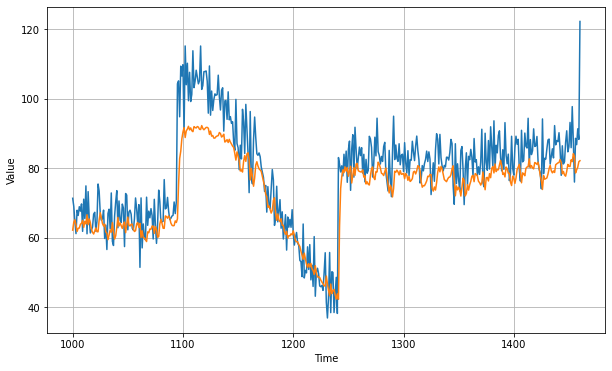

In [9]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [10]:
tf.keras.metrics.mean_absolute_error(x_valid, results).numpy()

6.610758

<Figure size 432x288 with 0 Axes>

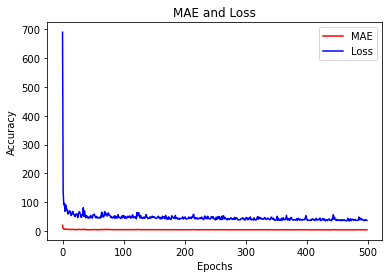

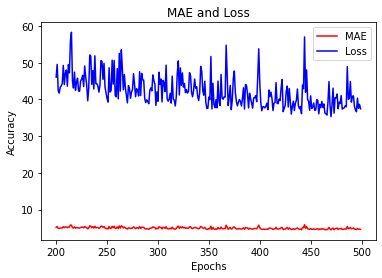

<Figure size 432x288 with 0 Axes>

In [11]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

In [12]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100, verbose=1)

Epoch 1/100
31/31 [==============================] - 4s 116ms/step - loss: 654.5930
Epoch 2/100
31/31 [==============================] - 1s 16ms/step - loss: 111.1845: 0s - loss: 128.
Epoch 3/100
31/31 [==============================] - 0s 16ms/step - loss: 81.1275
Epoch 4/100
31/31 [==============================] - 0s 15ms/step - loss: 74.0139
Epoch 5/100
31/31 [==============================] - 1s 17ms/step - loss: 60.1642
Epoch 6/100
31/31 [==============================] - 0s 15ms/step - loss: 57.0670
Epoch 7/100
31/31 [==============================] - 0s 15ms/step - loss: 57.3405
Epoch 8/100
31/31 [==============================] - 0s 15ms/step - loss: 53.9587
Epoch 9/100
31/31 [==============================] - 0s 15ms/step - loss: 57.4135
Epoch 10/100
31/31 [==============================] - 0s 15ms/step - loss: 49.0920
Epoch 11/100
31/31 [==============================] - 0s 15ms/step - loss: 48.5433
Epoch 12/100
31/31 [==============================] - 0s 15ms/step - loss: 5

31/31 [==============================] - 0s 15ms/step - loss: 50.1688
Epoch 100/100
31/31 [==============================] - 0s 14ms/step - loss: 45.5721


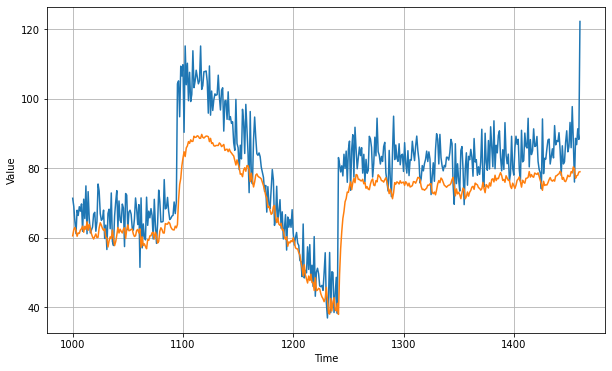

In [13]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [14]:
tf.keras.backend.clear_session()
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 [==============================] - 5s 160ms/step - loss: 637.1586
Epoch 2/100
31/31 [==============================] - 1s 21ms/step - loss: 120.7467
Epoch 3/100
31/31 [==============================] - 1s 21ms/step - loss: 92.0421
Epoch 4/100
31/31 [==============================] - 1s 21ms/step - loss: 88.8774
Epoch 5/100
31/31 [==============================] - 1s 21ms/step - loss: 82.8891
Epoch 6/100
31/31 [==============================] - 1s 20ms/step - loss: 75.1178
Epoch 7/100
31/31 [==============================] - 1s 20ms/step - loss: 68.2410
Epoch 8/100
31/31 [==============================] - 1s 20ms/step - loss: 64.0717
Epoch 9/100
31/31 [==============================] - 1s 21ms/step - loss: 66.8051
Epoch 10/100
31/31 [==============================] - 1s 20ms/step - loss: 65.6130
Epoch 11/100
31/31 [==============================] - 1s 21ms/step - loss: 62.4817
Epoch 12/100
31/31 [==============================] - 1s 20ms/step - loss: 58.0538
Epoch 13/1

31/31 [==============================] - 1s 19ms/step - loss: 44.4305
Epoch 100/100
31/31 [==============================] - 1s 19ms/step - loss: 45.0547


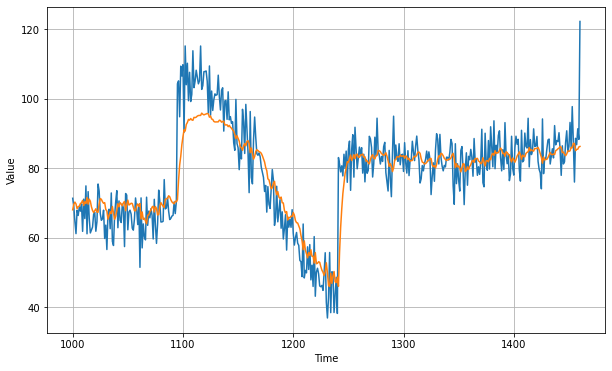

In [15]:
forecast = []
results = []
for time in range(len(series) - window_size):
    forecast.append(model.predict(series[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)